In [793]:
%run constants.ipynb
%run dataloaders.ipynb
%run utils.ipynb
%run models.ipynb
%run coresets.ipynb
%run train_and_test.ipynb
%run config.ipynb

In [794]:
def run_experiment_for(model, print_progress=False):
    config = model.config
    dataloaders = config.dataloaders
    coreset_alg = config.coreset_alg
    assert coreset_alg is None or coreset_alg.coresets == []  # should initially be empty
    results = np.zeros((len(config.tasks), len(config.tasks)))
    results_std = np.zeros((len(config.tasks), len(config.tasks)))
    is_vcl = isinstance(model, VCLNN)
    
    # Train and evaluate
    for task_id in range(len(config.tasks)):
        print_if(f"\nTraining on Task {task_id+1} ...", print_progress)
        train_loader, _ = dataloaders[task_id]
        # Train on non-coreset data
        train(model, train_loader, task_id)
        print_if(f"... Finished training on Task {task_id+1}", print_progress)
        
        # Train on new coreset
        if is_vcl and coreset_alg is not None and config.coreset_size > 0:  # VCL models with coresets
            coreset_alg.add_coreset(train_loader)
            # Train on coresets from previous tasks
            for prev_task in range(task_id+1):
                print_if(f"\nRe-training on Task {prev_task+1} ...", print_progress)
                train(model, coreset_alg.coresets[prev_task], prev_task)
        print_if('', print_progress)
        
        # Evaluate on previous tasks
        for curr_t in range(task_id+1):
            _, test_loader = dataloaders[curr_t]
            score, std = test(model, test_loader, curr_t, ret_std=True)
            print_if(f"Task {(curr_t+1):2d}  {config.eval_metric}: \
                        {np.round(score, 4):0.4f} ± {np.round(std, 4):0.4f}", print_progress)
            results[task_id, curr_t] = score
            results_std[task_id, curr_t] = std
        print_if('', print_progress)

        if is_vcl and config.update_prior:  # update prior for VCL models
            model.update_priors()
            
    return results, results_std

In [795]:
def run_experiment_multi(configs=None, task_type='classification', config_filter=None,
                         init_prior_scale=0.1, coreset_sizes=[50,100,200], 
                         print_progress=False, ret_std=True, show_vanilla=True):
    """Run complete VCL experiment"""
    if configs is None:
        configs = get_all_configs(task_type, config_filter,
                                  init_prior_scale, coreset_sizes)
    # Initialize models
    models = {c.name: VCLNN(c).to(DEVICE) for c in configs}
    if show_vanilla:
        vanillaNN = VanillaNN(ExperimentConfig()).to(DEVICE) 
        models[VANILLA_MODEL] = vanillaNN

    results = {}
    results_std = {}
    for model_name, model in models.items():
        res, res_std = run_experiment_for(model, print_progress=print_progress)
        results[model_name] = res
        results_std[model_name] = res_std
    return results if not ret_std else (results, results_std)

# Results

In [797]:
torch.manual_seed(77)
np.random.seed(77)
configs = get_all_configs('classification')
cla_results, cla_std = run_experiment_multi(configs=configs, task_type='classification')

### Aggregated results for models using Kcenter coresets of size 100

In [820]:
# Mean lifetime test accuracies
mean_aggr_results(cla_results, aggr='all', ret_std=True,
                  mname_filter=(lambda m: 'Kcenter, 100' in m or m == VANILLA_MODEL))

({'ExpVCL (Kcenter, 100)': 0.9945261402676504,
  'GaussianVCL (Kcenter, 100)': 0.991290180351999,
  'Vanilla': 0.9816353299468755},
 {'ExpVCL (Kcenter, 100)': 0.004226084438426587,
  'GaussianVCL (Kcenter, 100)': 0.007039663716523697,
  'Vanilla': 0.01752729540605469})

In [821]:
# Mean final test accuracies
mean_aggr_results(cla_results, aggr='final', ret_std=True,
                  mname_filter=(lambda m: 'Kcenter, 100' in m or m == VANILLA_MODEL))

({'ExpVCL (Kcenter, 100)': 0.993739624818166,
  'GaussianVCL (Kcenter, 100)': 0.9858465355303553,
  'Vanilla': 0.9819422024819586},
 {'ExpVCL (Kcenter, 100)': 0.004936723763742528,
  'GaussianVCL (Kcenter, 100)': 0.013564528783358407,
  'Vanilla': 0.016373638319312295})

### Plots

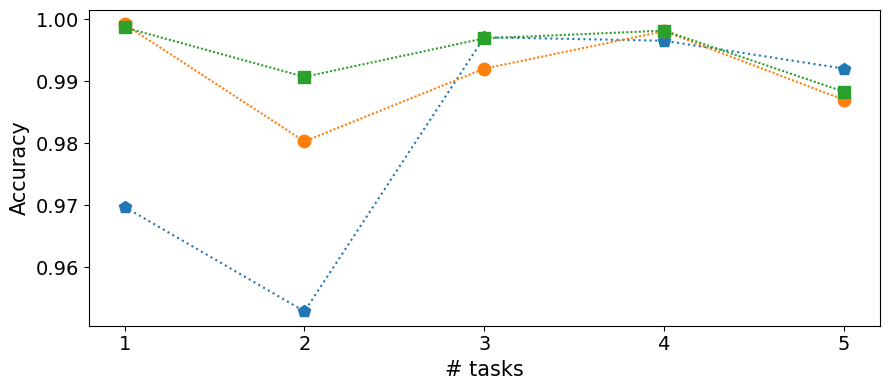

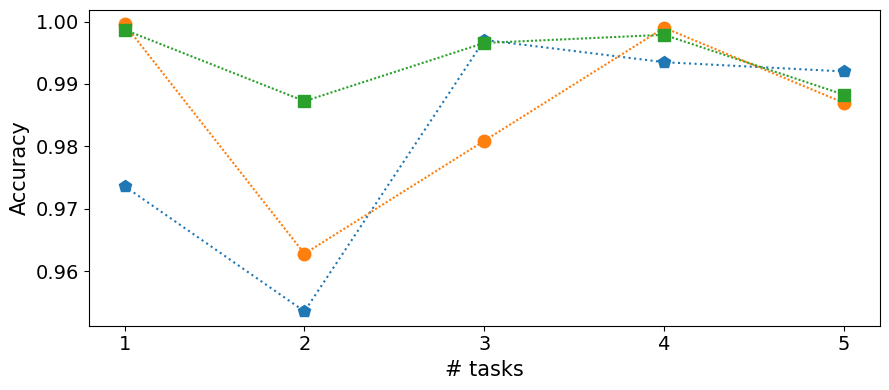

In [822]:
plot_mean_results(ExperimentConfig(task_type='classification'), cla_results, 
                  mname_filter=(lambda m: 'Kcenter, 100' in m or m == VANILLA_MODEL),
                  loc=None, bbox_to_anchor=None, figsize=(9,4), legend=False)
plot_final_results(ExperimentConfig(task_type='classification'), cla_results, 
                   mname_filter=(lambda m: 'Kcenter, 100' in m or m == VANILLA_MODEL),
                   loc=None, bbox_to_anchor=None, figsize=(9,4), legend=False)

## Regression

In [823]:
torch.manual_seed(77)
np.random.seed(77)
configs = get_all_configs('regression')
reg_results, reg_std = run_experiment_multi(configs=configs, task_type='regression')

### Aggregated results for models using random coresets of size 200

In [829]:
# Mean lifetime test RMSEs
mean_aggr_results(reg_results, aggr='all', ret_std=True,
                  mname_filter=(lambda m: ('Kcenter, 200' in m) or m == VANILLA_MODEL))

({'ExpVCL (Kcenter, 200)': 0.17901832463219763,
  'GaussianVCL (Kcenter, 200)': 0.13301292509461443,
  'Vanilla': 0.9666586900171307},
 {'ExpVCL (Kcenter, 200)': 0.04718133177851645,
  'GaussianVCL (Kcenter, 200)': 0.011271898358284136,
  'Vanilla': 0.034571736918419915})

In [833]:
# Mean final test RMSEs
mean_aggr_results(reg_results, aggr='final', ret_std=True,
                  mname_filter=(lambda m: ('Kcenter, 200' in m) or m == VANILLA_MODEL))

({'ExpVCL (Kcenter, 200)': 0.20549062649822897,
  'GaussianVCL (Kcenter, 200)': 0.14360651100675265,
  'Vanilla': 0.9521837981210816},
 {'ExpVCL (Kcenter, 200)': 0.05863671749137695,
  'GaussianVCL (Kcenter, 200)': 0.008386367148591147,
  'Vanilla': 0.05310951621738408})

### Plots

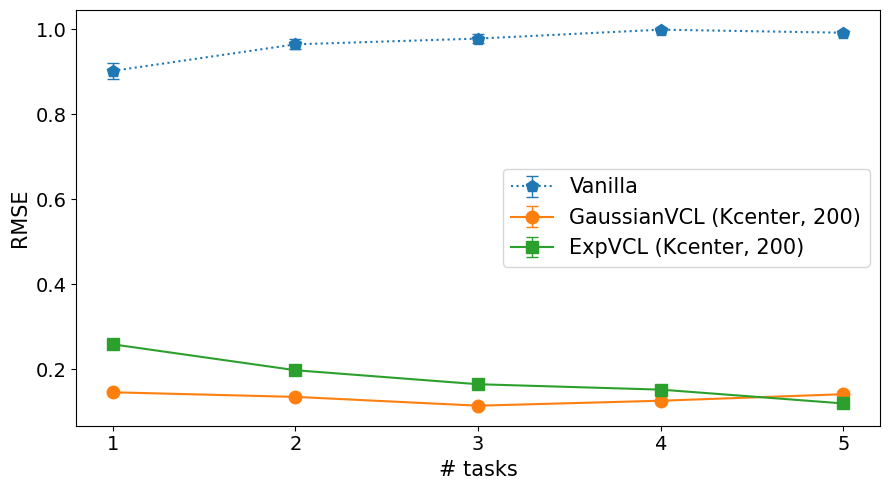

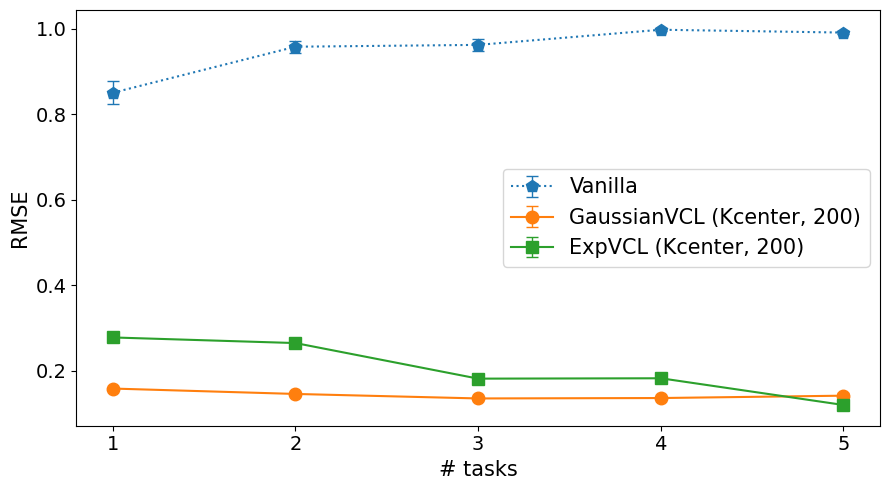

In [826]:
plot_mean_results(ExperimentConfig(task_type='regression'), reg_results, results_std=reg_std,
                 mname_filter=(lambda m : 'Kcenter, 200' in m or m == VANILLA_MODEL),
                 loc=None, bbox_to_anchor=None, figsize=(9,5))
plot_final_results(ExperimentConfig(task_type='regression'), reg_results, results_std=reg_std,
                  mname_filter=(lambda m : 'Kcenter, 200' in m or m == VANILLA_MODEL),
                  loc=None, bbox_to_anchor=None, figsize=(9,5))

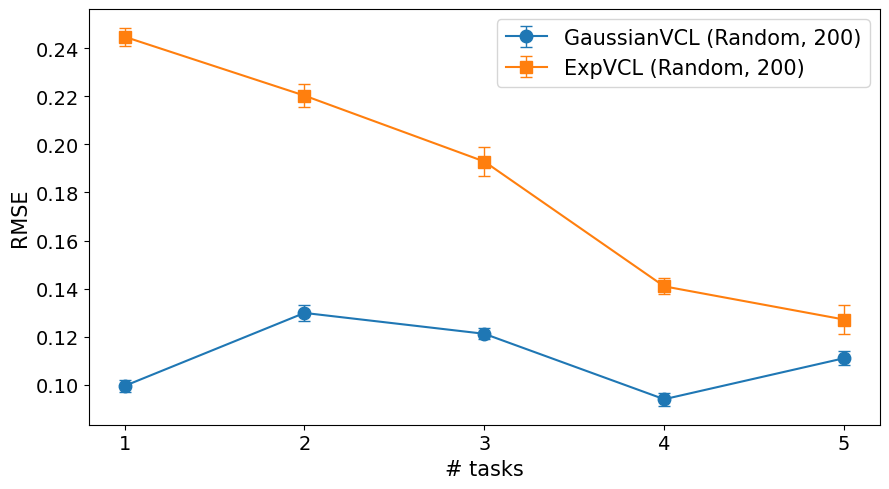

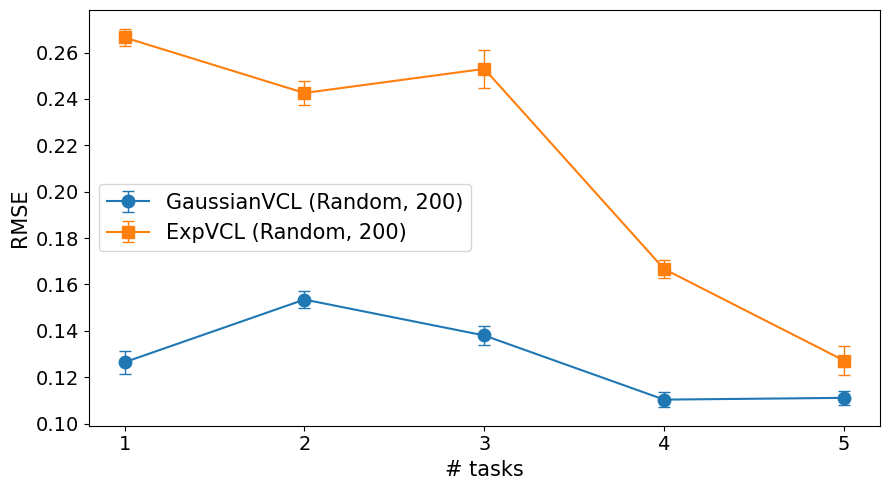

In [825]:
# Without the vanilla model
plot_mean_results(ExperimentConfig(task_type='regression'), reg_results, results_std=reg_std,
                 mname_filter=(lambda m : 'Random, 200' in m),
                 loc=None, bbox_to_anchor=None, figsize=(9,5))
plot_final_results(ExperimentConfig(task_type='regression'), reg_results, results_std=reg_std,
                  mname_filter=(lambda m : 'Random, 200' in m),
                  loc=None, bbox_to_anchor=None, figsize=(9,5))

# Results

## Classification

In [777]:
torch.manual_seed(77)
np.random.seed(77)
configs = get_all_configs('regression', 
                          config_filter=(lambda c: c.coreset_alg_name=='random' and c.coreset_size==200))
reg_results, reg_std = run_experiment_multi(configs=configs, task_type='regression')

In [778]:
cla_all_results

{'GaussianVCL (Random, 200)': array([[0.99956597, 0.        , 0.        , 0.        , 0.        ],
        [0.99956597, 0.88107812, 0.        , 0.        , 0.        ],
        [0.99956597, 0.89813282, 0.90516625, 0.        , 0.        ],
        [0.99956597, 0.93192969, 0.92872284, 0.98765706, 0.        ],
        [0.99956597, 0.89816797, 0.95105278, 0.99267578, 0.89789809]]),
 'ExpVCL (Kcenter, 50)': array([[0.99956597, 0.        , 0.        , 0.        , 0.        ],
        [0.99956597, 0.83792187, 0.        , 0.        , 0.        ],
        [0.99956597, 0.73799609, 0.89778249, 0.        , 0.        ],
        [0.99913194, 0.90389844, 0.89239948, 0.89777807, 0.        ],
        [0.99913194, 0.86519531, 0.91309784, 0.9653723 , 0.86791608]]),
 'GaussianVCL (Random, 100)': array([[0.99956597, 0.        , 0.        , 0.        , 0.        ],
        [0.99956597, 0.96229687, 0.        , 0.        , 0.        ],
        [0.99956597, 0.96130859, 0.96063977, 0.        , 0.        ],
    

### Aggregated results for models using random coresets of size 200

In [779]:
# Mean lifetime test accuracies
mean_aggr_results(cla_all_results, aggr='all', ret_std=True,
                  mname_filter=(lambda m: 'Random, 200' in m or m == VANILLA_MODEL))

({'GaussianVCL (Random, 200)': 0.9436543184436029,
  'ExpVCL (Random, 200)': 0.9484624577727583,
  'Vanilla': 0.9709746509542068},
 {'GaussianVCL (Random, 200)': 0.04318884627008079,
  'ExpVCL (Random, 200)': 0.04789313789733377,
  'Vanilla': 0.02964211228512102})

In [780]:
# Mean final test accuracies
mean_aggr_results(cla_all_results, aggr='final', ret_std=True,
                  mname_filter=(lambda m: ('Random, 200' in m) or m == VANILLA_MODEL))

({'GaussianVCL (Random, 200)': 0.9478721198108462,
  'ExpVCL (Random, 200)': 0.9515611698230106,
  'Vanilla': 0.9419272881415155},
 {'GaussianVCL (Random, 200)': 0.04394916423003002,
  'ExpVCL (Random, 200)': 0.047217853107922994,
  'Vanilla': 0.065248725665469})

In [789]:
mean_aggr_results(cla_all_results, aggr='all', ret_std=False)

{'GaussianVCL (Random, 200)': 0.9436543184436029,
 'ExpVCL (Kcenter, 50)': 0.9072459668003852,
 'GaussianVCL (Random, 100)': 0.9685218647536304,
 'ExpVCL (Kcenter, 200)': 0.9246855895635153,
 'ExpVCL (Random, 50)': 0.9345906394885646,
 'GaussianVCL (Kcenter, 50)': 0.897016469736894,
 'ExpVCL (Random, 200)': 0.9484624577727583,
 'ExpVCL (Kcenter, 100)': 0.8535732279055648,
 'GaussianVCL (Random, 50)': 0.9192194078365962,
 'ExpVCL (None)': 0.9783323766456711,
 'GaussianVCL (Kcenter, 200)': 0.9032910292264488,
 'ExpVCL (Random, 100)': 0.9389617696983947,
 'GaussianVCL (Kcenter, 100)': 0.8965451323572132,
 'GaussianVCL (None)': 0.9847571187631952,
 'Vanilla': 0.9709746509542068}

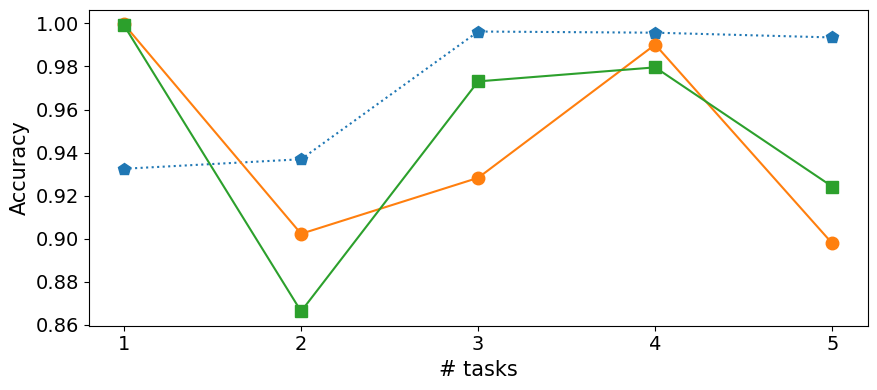

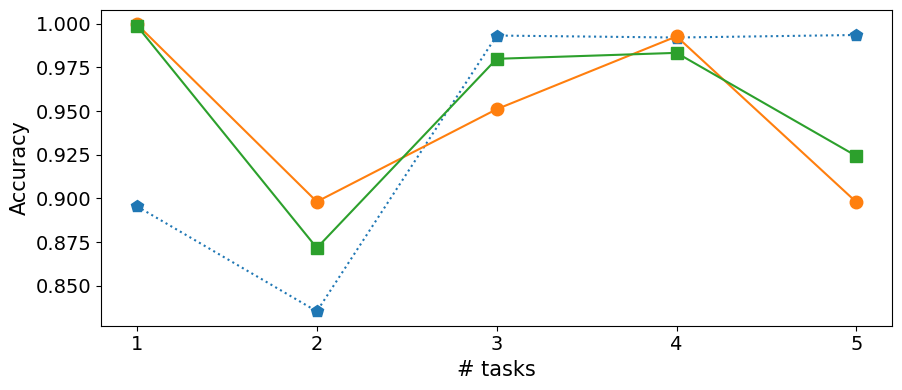

In [790]:
plot_mean_results(ExperimentConfig(task_type='classification'), cla_all_results, 
                  mname_filter=(lambda m : 'Random, 200' in m or m == VANILLA_MODEL),
                  loc=None, bbox_to_anchor=None, figsize=(9,4), legend=False)
plot_final_results(ExperimentConfig(task_type='classification'), cla_all_results, 
                   mname_filter=(lambda m : 'Random, 200' in m  or m == VANILLA_MODEL),
                   loc=None, bbox_to_anchor=None, figsize=(9,4), legend=False)

### Plots

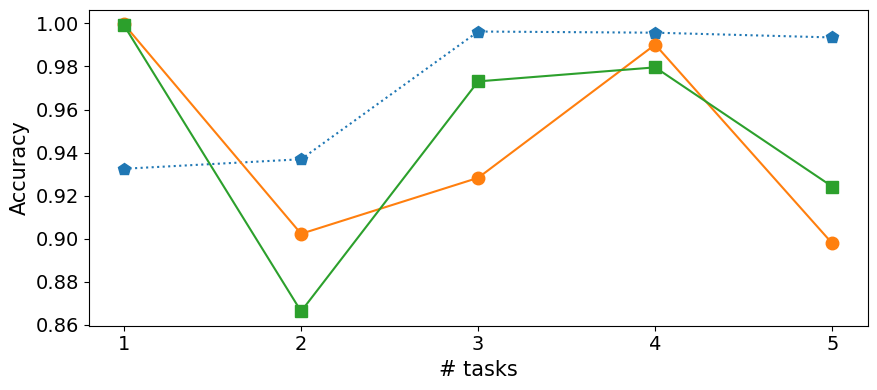

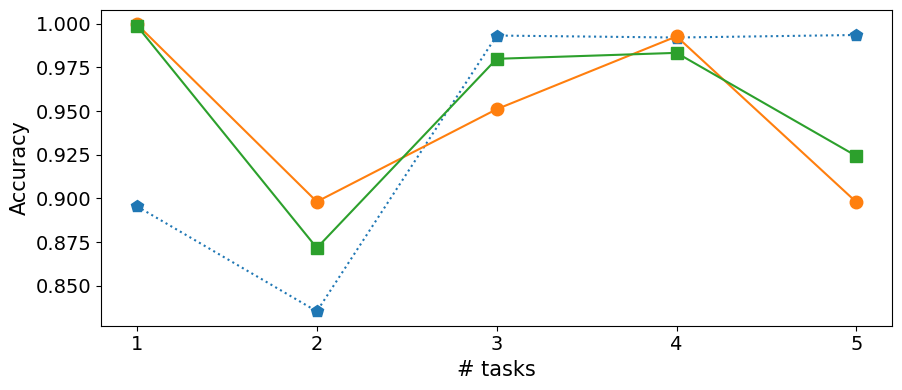

In [781]:
%run utils.ipynb
plot_mean_results(ExperimentConfig(task_type='classification'), cla_all_results, 
                  mname_filter=(lambda m : 'Random, 200' in m or m == VANILLA_MODEL),
                  loc=None, bbox_to_anchor=None, figsize=(9,4), legend=False)
plot_final_results(ExperimentConfig(task_type='classification'), cla_all_results, 
                   mname_filter=(lambda m : 'Random, 200' in m  or m == VANILLA_MODEL),
                   loc=None, bbox_to_anchor=None, figsize=(9,4), legend=False)

## Regression

In [782]:
torch.manual_seed(77)
np.random.seed(77)
configs = get_all_configs('regression')
reg_all_results, reg_all_std = run_experiment_multi(configs=configs, task_type='regression')

### Aggregated results for models using random coresets of size 200

In [783]:
# Mean lifetime test RMSEs
mean_aggr_results(reg_all_results, aggr='all', ret_std=True,
                  mname_filter=(lambda m: ('Random' in m and '200' in m) or 'None' in m or m == VANILLA_MODEL))

({'GaussianVCL (Random, 200)': 0.11114799663631451,
  'ExpVCL (Random, 200)': 0.1851843152857489,
  'ExpVCL (None)': 0.20776990501830978,
  'GaussianVCL (None)': 0.1542945086956024,
  'Vanilla': 0.9666586900171307},
 {'GaussianVCL (Random, 200)': 0.0132750348431405,
  'ExpVCL (Random, 200)': 0.045068673500492096,
  'ExpVCL (None)': 0.07830224676288239,
  'GaussianVCL (None)': 0.06362227604237942,
  'Vanilla': 0.034571736918419915})

In [792]:
# Mean final test RMSEs
mean_aggr_results(reg_all_results, aggr='final', ret_std=True,
                  mname_filter=(lambda m: ('Random' in m and '200' in m) or 'None' in m or m == VANILLA_MODEL))

({'GaussianVCL (Random, 200)': 0.1278431293865045,
  'ExpVCL (Random, 200)': 0.21114822365343572,
  'ExpVCL (None)': 0.24774218745943574,
  'GaussianVCL (None)': 0.19721489438994064,
  'Vanilla': 0.9521837981210816},
 {'GaussianVCL (Random, 200)': 0.01643114285870639,
  'ExpVCL (Random, 200)': 0.05446513815976271,
  'ExpVCL (None)': 0.0924208412231561,
  'GaussianVCL (None)': 0.08393831172918884,
  'Vanilla': 0.05310951621738408})

### Plots

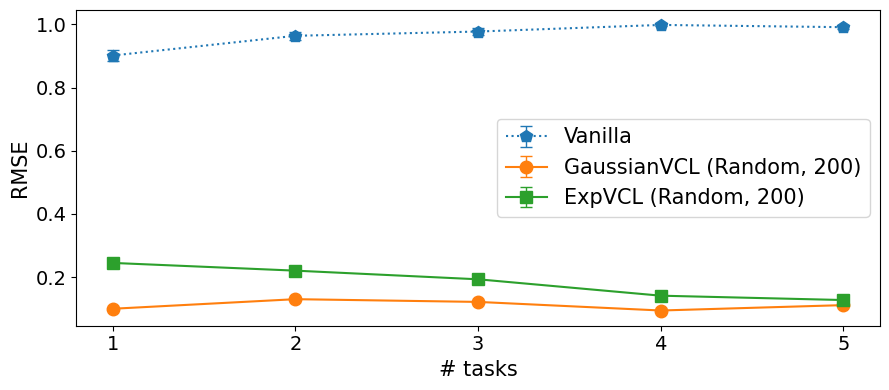

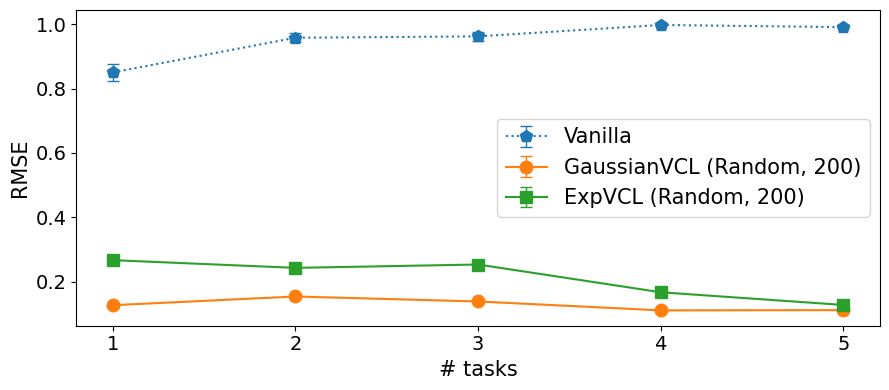

In [791]:
plot_mean_results(ExperimentConfig(task_type='regression'), reg_all_results, results_std=reg_all_std,
                 mname_filter=(lambda m : 'Random, 200' in m or m == VANILLA_MODEL),
                 loc=None, bbox_to_anchor=None, figsize=(9,4))
plot_final_results(ExperimentConfig(task_type='regression'), reg_all_results, results_std=reg_all_std,
                  mname_filter=(lambda m : 'Random, 200' in m or m == VANILLA_MODEL),
                  loc=None, bbox_to_anchor=None, figsize=(9,4))

## Optionally Import & Export Results

In [834]:
# export results
export_results(cla_results, 'classification', datatype='mean')
export_results(cla_std, 'classification', datatype='std')
export_results(reg_results, 'regression', datatype='mean')
export_results(reg_std, 'regression', datatype='std')

In [689]:
# import results
%run utils.ipynb
cla_results = import_results('classification', datatype='mean')
cla_std = import_results('classification', datatype='std')
reg_results = import_results('regression', datatype='mean')
reg_std = import_results('regression', datatype='std')